# CLASSIFYING NEWS TEXT INTO THE PREDEFINED LABELS

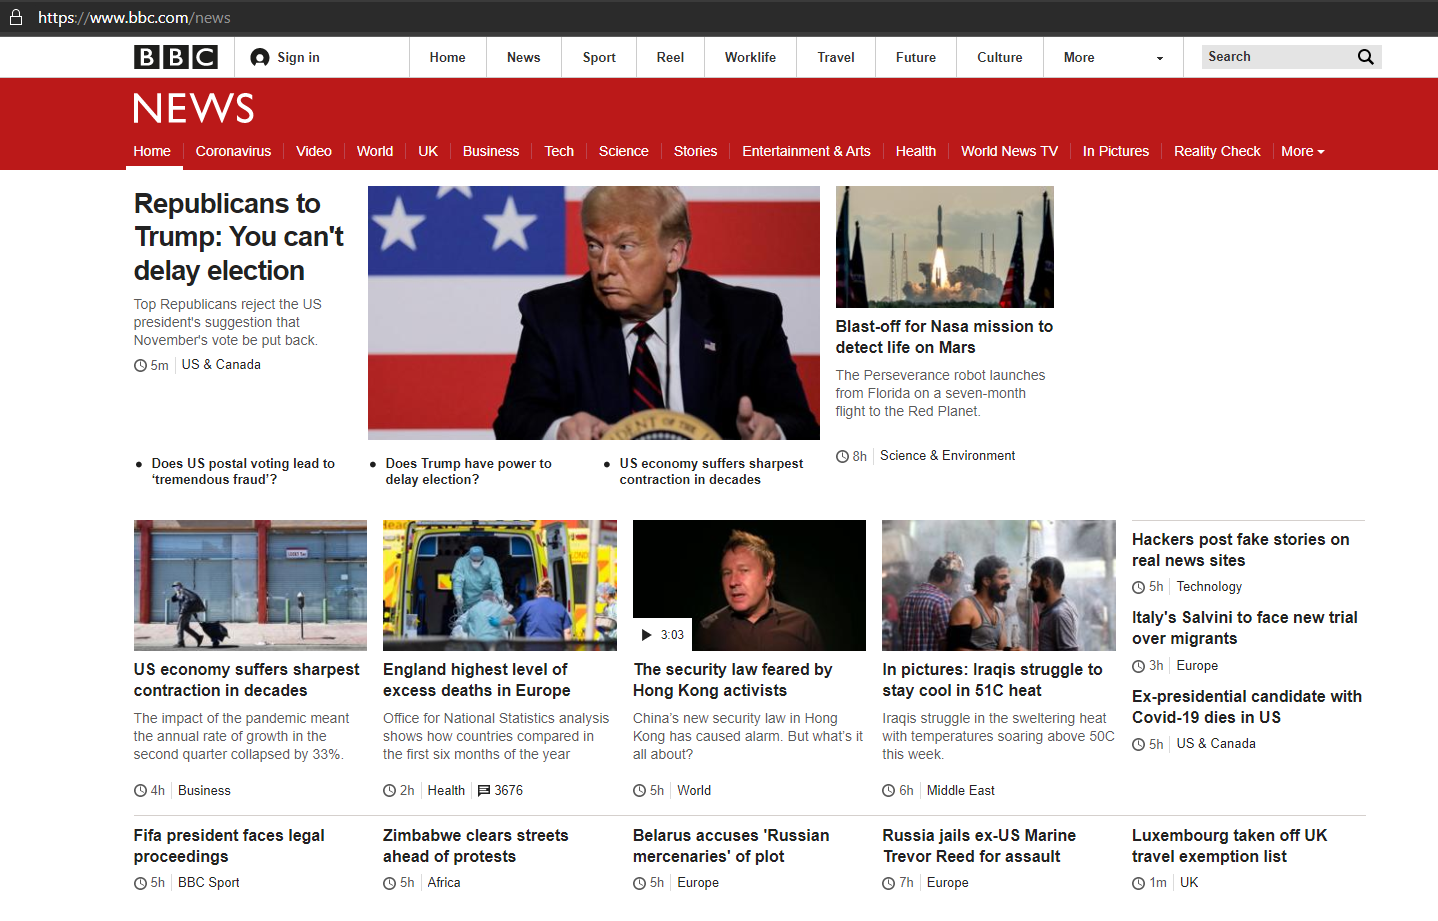

>You may have already noticed and used the categories in the news websites for accessing the topics that you would like to learn the associated recent developments. Categorizing a new content can be actually done autonomously using Supervised Learning, looking at the past news content and the labels: our ML model can predict the category of a given recent news, this method is particularly called the text classification.

>To illustrate, you can see above the individual news on the BBC News website and their labels such as Business, Health, World, Europe, etc. Using an open dataset called "BBC News Archive", we will be training a neural network predicting the labels of unseen news based on this labeled data set.

>We can treat this as a general ML problem by generating word indexes for each word in the news content, or we can be more spesific and consider the interrelations of the words by using pretrained word embeddings.

The original source of the data may be accessed through [this link ](http://mlg.ucd.ie/datasets/bbc.html)and it might be interesting to read the associated [research article](http://mlg.ucd.ie/files/publications/greene06icml.pdf). Before giving further details regarding the data, let's discover it together through an Exploratory Data Analysis (EDA).

# Exploratory Data Analysis (EDA)

Importing the required modules:

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix

sns.set_style('darkgrid')

In [ ]:
df = pd.read_csv('../input/bbcnewsarchive/bbc-news-data.csv', sep='\t')
df

In [ ]:
df.info()

In [ ]:
df.category.value_counts()

In [ ]:
stopwords = set(stopwords.words('english'))

In [ ]:
set(list(stopwords)[0:15]) #showing only the first 15 elements of the stopwords set

In [ ]:
len(stopwords)

In [ ]:
contents_clean = []
for content_clean in df.content:
    for word in stopwords:
        token = " " + word + " "
        content_clean = content_clean.replace(token, " ")
    contents_clean.append(content_clean)

In [ ]:
df['content_clean'] = np.array(contents_clean)

In [ ]:
df.head()

In [ ]:
len(df.content_clean[2224])

In [ ]:
plt.figure(figsize = (12, 6))
sns.countplot(df.category)

# Train-Test Split

In [ ]:
X = list(df.content_clean)
y = list(df.category)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42, shuffle = True)

In [ ]:
unique_elements_train, counts_elements_train = np.unique(y_train, return_counts=True)
print("Frequency of unique labels in the train set:")
print(np.asarray((unique_elements_train, counts_elements_train)))

In [ ]:
unique_elements_test, counts_elements_test = np.unique(y_test, return_counts=True)
print("Frequency of unique labels in the test set:")
print(np.asarray((unique_elements_test, counts_elements_test)))

In [ ]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

# Transforming Article Text to Feature Vector

In [ ]:
vocab_size = 15000
embedding_dim = 32
max_length = 256
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [ ]:
X_train_sqncs = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_sqncs, padding=padding_type, maxlen=max_length)

X_test_sqncs = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sqncs, padding=padding_type, maxlen=max_length)

print(len(X_test_sqncs))
print(X_test_padded.shape)

In [ ]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(df.category)
label_index = label_tokenizer.word_index

y_train_label_sqncs = np.array(label_tokenizer.texts_to_sequences(y_train))
y_test_label_sqncs = np.array(label_tokenizer.texts_to_sequences(y_test))

print(y_train_label_sqncs[0])
print(y_train_label_sqncs[1])
print(y_train_label_sqncs[2])
print(y_train_label_sqncs.shape)

print(y_test_label_sqncs[0])
print(y_test_label_sqncs[1])
print(y_test_label_sqncs[2])
print(y_test_label_sqncs.shape)

In [ ]:
len(word_index)

In [ ]:
dict(list(word_index.items())[0:15]) #showing only the first 15 elements of the word_index dictionary

In [ ]:
label_index

# Model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

In [ ]:
num_epochs = 35
history = model.fit(X_train_padded, y_train_label_sqncs, epochs=num_epochs, validation_data=(X_test_padded, y_test_label_sqncs), verbose=2)

In [ ]:
y_pred = model.predict_classes(X_test_padded)

In [ ]:
X_test_padded

In [ ]:
y_pred

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'])

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_content(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

reverse_label_index = dict([(value, key) for (key, value) in label_index.items()])

def decode_labels(text):
    text = np.array([text])
    return ' '.join([reverse_label_index.get(i, '?') for i in text])

### Checking a few articles and their category:

#### News Article 1

In [ ]:
X_test[1]

In [ ]:
y_test[1]

In [ ]:
decode_content(X_test_padded[1])

In [ ]:
decode_labels(y_pred[1])

#### News Article 2:

In [ ]:
X_test[34]

In [ ]:
y_test[34]

In [ ]:
decode_content(X_test_padded[34])

In [ ]:
decode_labels(y_pred[34])

#### News Article 3:

In [ ]:
X_test[400]

In [ ]:
y_test[400]

In [ ]:
decode_content(X_test_padded[400])

In [ ]:
decode_labels(y_pred[400])

In [ ]:
df.category.drop_duplicates().values

In [ ]:
plt.figure(figsize=(14,10))
conf_mat = confusion_matrix(y_test_label_sqncs, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="YlGnBu",
            xticklabels=list(label_index.keys()), yticklabels=list(label_index.keys()))
plt.ylabel('Actual')
plt.xlabel('Predicted')

The result seems quite satisfying, of course we had a pretty clean text data set with plain English written by the professional journalists, however this is not always the case. For example, if we were to categorize indivudual items in a retail website, where the content was created by distinct sellers, then we might have needed to perform a detalied text processing! However, for the purposes of this notebook, we do not need much of a preprocessing, nevertheless it could be good practice to utilize pretrained word embeddings that is trained on a larger corpus with much fair generalization of the word vector representations! 